In [87]:
%matplotlib notebook

In [88]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal
from astropy.io import fits
from IPython.display import display, Math, Image

In [3]:
dir = "C:/Users/Marc/Documents/stage_m2/stage_m2/plots/TESS_20_21_0/"

<IPython.core.display.Javascript object>


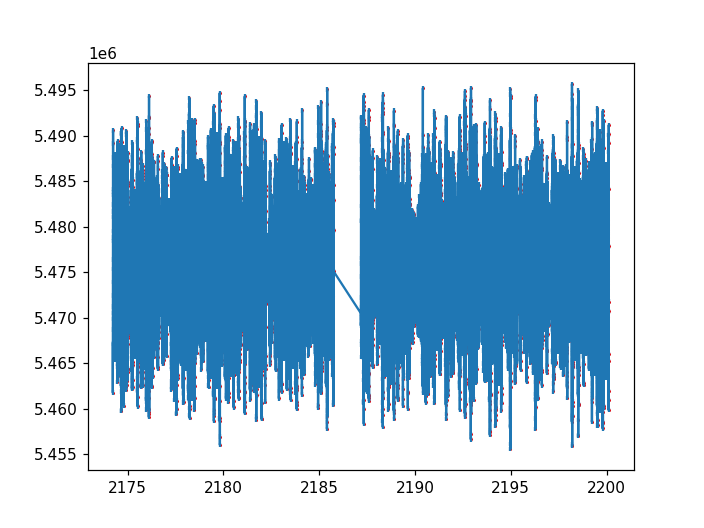

array([21878.213, 21861.293, 21882.918, ..., 21854.207, 21858.133,
       21855.248], dtype=float32)

In [183]:
### TESS 2020_2021 data import ###
hdul = fits.open("tess2020324010417-s0032-0000000270577175-0200-s_lc.fits")

#SAP_FLUX, PDCSAP_FLUX, SAP_BKG, QUALITY
data = hdul[1].data
time = data['TIME']
flux = data['PDCSAP_FLUX']
flux_error = data['PDCSAP_FLUX_ERR']
# index = np.argwhere((time<2186) & (time>2173) & (~np.isnan(flux)) & (data["QUALITY"] == 0))
index = np.argwhere((~np.isnan(flux)) & (data["QUALITY"] == 0))
time = np.ndarray.flatten(time[index])
flux_error = np.ndarray.flatten(flux_error[index])
flux = np.ndarray.flatten(flux[index])
# flux_error = flux + flux_error
# flux_error = (flux_error - np.mean(flux))/(np.max(flux) - np.mean(flux))
# flux = (flux - np.mean(flux))/(np.max(flux) - np.mean(flux))
# flux_error = flux_error - flux
plt.figure()
plt.scatter(time,flux,s=1,c='r')
plt.errorbar(time,flux,yerr=flux_error,markersize=1,capsize=0,fmt="-")
plt.show()
flux/flux_error

In [184]:
### GP Model ###
bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=1., log_Q=2.5, log_omega0=5.80,bounds=bounds)


gp = celerite.GP(kernel,mean=np.mean(flux))
gp.compute(time,yerr=flux_error)


print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -2162697.689318698
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])



In [192]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


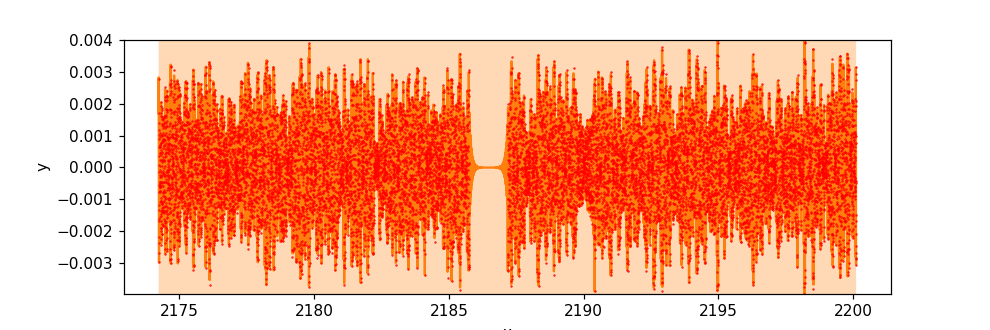

array([ 0.00169336,  0.00282007,  0.00195024, ..., -0.00224045,
       -0.00302883, -0.00285832])

In [71]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.nanmin(flux),np.nanmax(flux))
plt.show()

In [185]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: 144553.60019277647
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.69558155, -27.08111424,  40.71043804])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 304
      nit: 32
   status: 0
  success: True
        x: array([8.86212785, 2.95460591, 5.74420352])
Final log-likelihood: -144553.60019277647
[7059.48829007   19.19415698  312.37472904]
Parameters: OrderedDict([('kernel:log_S0', 8.862127847700213), ('kernel:log_Q', 2.9546059087592282), ('kernel:log_omega0', 5.744203531723625)])


In [9]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


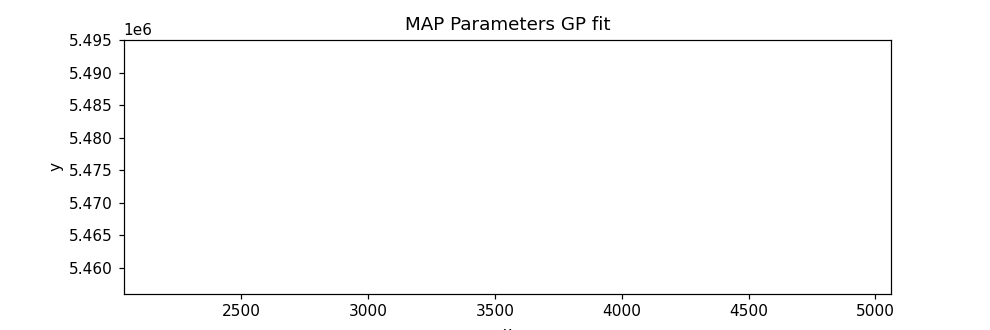

In [163]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux-np.mean(flux),yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [186]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [187]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-30 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7)) :
        return 0
    return -np.inf

In [188]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [189]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

Running burn-in...


100%|██████████| 500/500 [04:49<00:00,  1.72it/s]


Running production...


100%|██████████| 5000/5000 [48:17<00:00,  1.73it/s]

Finished


In [190]:
af = sampler.acceptance_fraction
print("Mean acceptance fraction:", np.mean(af))
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Mean acceptance fraction: 0.646596875
Final MCMC Parameters: OrderedDict([('kernel:log_S0', 8.863460399455636), ('kernel:log_Q', 2.929428462170631), ('kernel:log_omega0', 5.741986448044406)])
Final MCMC log likelihood: -144554.47405473824


In [111]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[1.50066050e-05 7.27733569e+01 3.05940763e+02]


48.69198473726045

In [112]:
P = 1/f
print("periode :",P*24*60,"min")

periode : 29.57365586492662 min


In [113]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


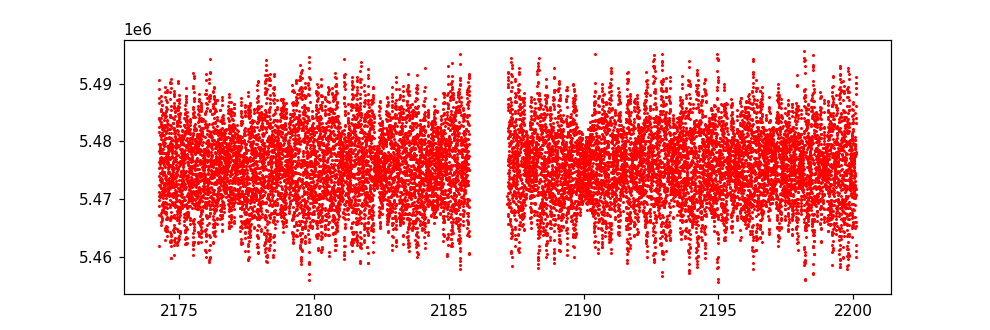

NameError: name 'x' is not defined

In [26]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>


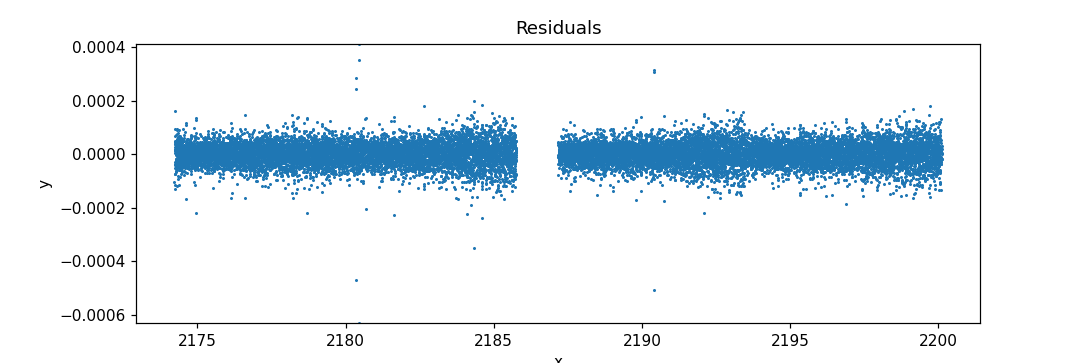

In [80]:
### Résidus ###
pred_mean, pred_var = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux - pred_mean,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux - pred_mean),np.max(flux - pred_mean))
plt.title("Residuals")
plt.show()

<IPython.core.display.Javascript object>


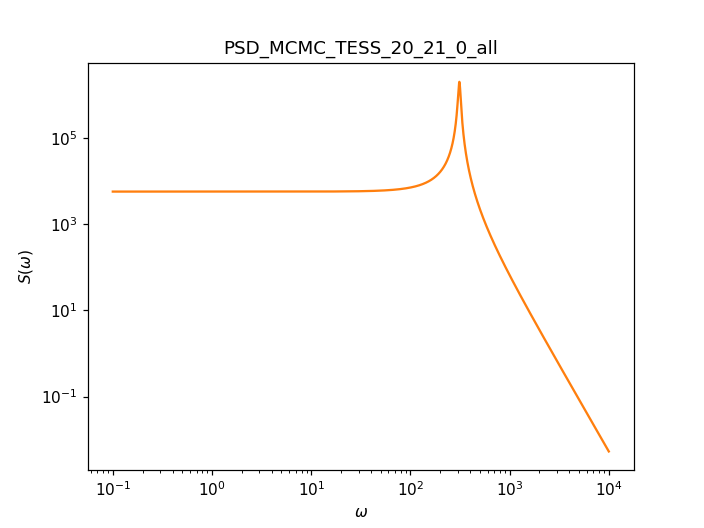

In [191]:
### PSD en fonction de omega ###
color = "#ff7f0e"
plt.figure()
omega = np.exp(np.linspace(np.log(0.1), np.log(10000), 5000))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd, color=color)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$")
plt.title("PSD_MCMC_TESS_20_21_0_all")
plt.show()
plt.savefig(dir+"PSD_MCMC_TESS_20_21_0_all.pdf",bbox_inches='tight')

In [192]:
### Récupération des hyperparamètres et Résultats ###
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["log(S0)","log(Q)","log(w0)"]
posteriors = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    value = np.percentile(flat_samples[:, i], [50])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    posteriors.append(value)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


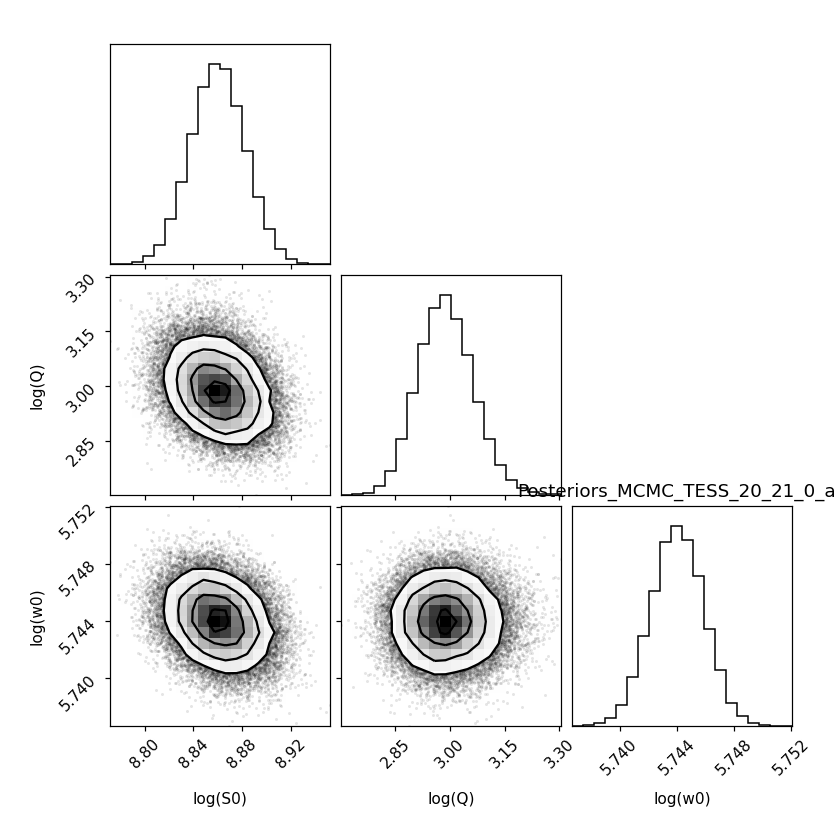

In [193]:
### Posteriors ###
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
plt.title("Posteriors_MCMC_TESS_20_21_0_all")
plt.show()
plt.savefig(dir+"Posteriors_MCMC_TESS_20_21_0_all.pdf",bbox_inches='tight')

In [29]:
tau = sampler.get_autocorr_time()
print(tau)

[38.75780568 37.40575546 38.60888621]


<IPython.core.display.Javascript object>


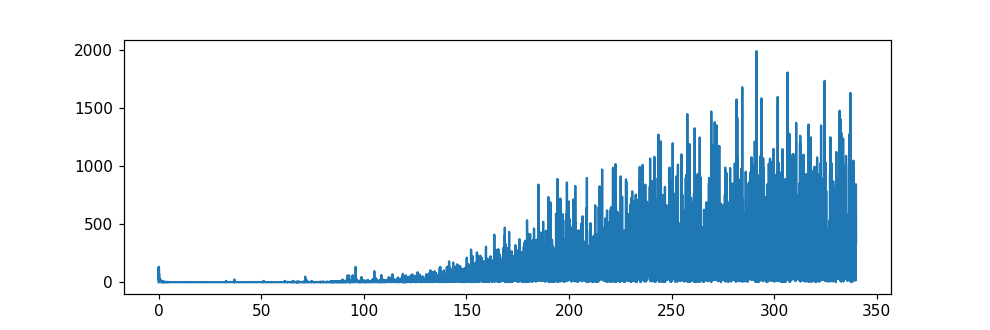

freq: 291.31418233592956 d-1
periode 4.9431167011960335 min


In [30]:
### Périodogramme des résidus ###
fs = len(time)/(time[-1] - time[0])
f,pxx = signal.periodogram(flux - pred_mean,fs)
plt.figure(figsize=(9,3))
plt.plot(f,pxx)
plt.show()
idx = np.argmax(pxx)
print("freq:", f[idx],"d-1")
print("periode",1/f[idx]*60*24,"min")

In [94]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_flux = rv_data[:,1]
rv_error = rv_data[:,2]
index = np.argwhere(rv_time)
rv_flux = np.ndarray.flatten(rv_flux[index])*1000
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])*1000

<IPython.core.display.Javascript object>


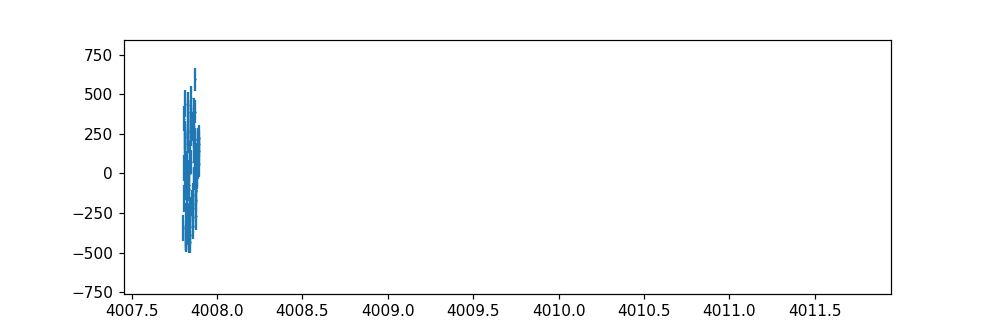

In [95]:
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=1,capsize=0,fmt='.')
plt.show()

In [76]:
def log_likelihood(params,time,flux):
        gp.set_parameter_vector(params)
        ll = gp.log_likelihood(flux)
        return ll if np.isfinite(ll) else -np.inf

### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-30 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7) and (-1000 < params[3] < 1000)) :
        return 0
    return -np.inf

### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

    ### MCMC ###
def run_mcmc(time,flux,gp) :
    initial = gp.get_parameter_vector()
    ndim, nwalkers = len(initial), 128
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, 5000,progress=True)
    print("Finished")
    
    likelihood = gp.log_likelihood(flux)
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))
    return(sampler,likelihood)

In [77]:
def gp_building(posteriors,time,error) :
    bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
    #kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
    kernel = terms.SHOTerm(log_S0=posteriors[0], log_Q=posteriors[1], log_omega0=posteriors[2],bounds=bounds)


    gp = celerite.GP(kernel,fit_mean=True)
    gp.compute(time,yerr=error)

    print("Initial log likelihood: {0}".format(gp.log_likelihood(rv_flux)))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    
    return gp

In [78]:
file = open("res_TESS_20_21_0_RV_single_obs.txt",'w')
file.write("Borne_inf Borne_sup Likelihood log(S0) log(Q) log(w0) Offset Errors_inf S0,Q,w0,Offset Errors_sup S0,Q,w0,Offset\n")
file.close()

  0%|          | 0/500 [00:00<?, ?it/s]

0
Initial log likelihood: -1611.973588287221
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:12<00:00, 39.36it/s]


Running production...


100%|██████████| 5000/5000 [02:08<00:00, 38.90it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 2.5606780775902735), ('kernel:log_Q', 1.7386235968651487), ('kernel:log_omega0', 5.701403931657447), ('mean:value', 61.02638513888871)])

Final MCMC log likelihood: -1386.2898574827057


<IPython.core.display.Javascript object>


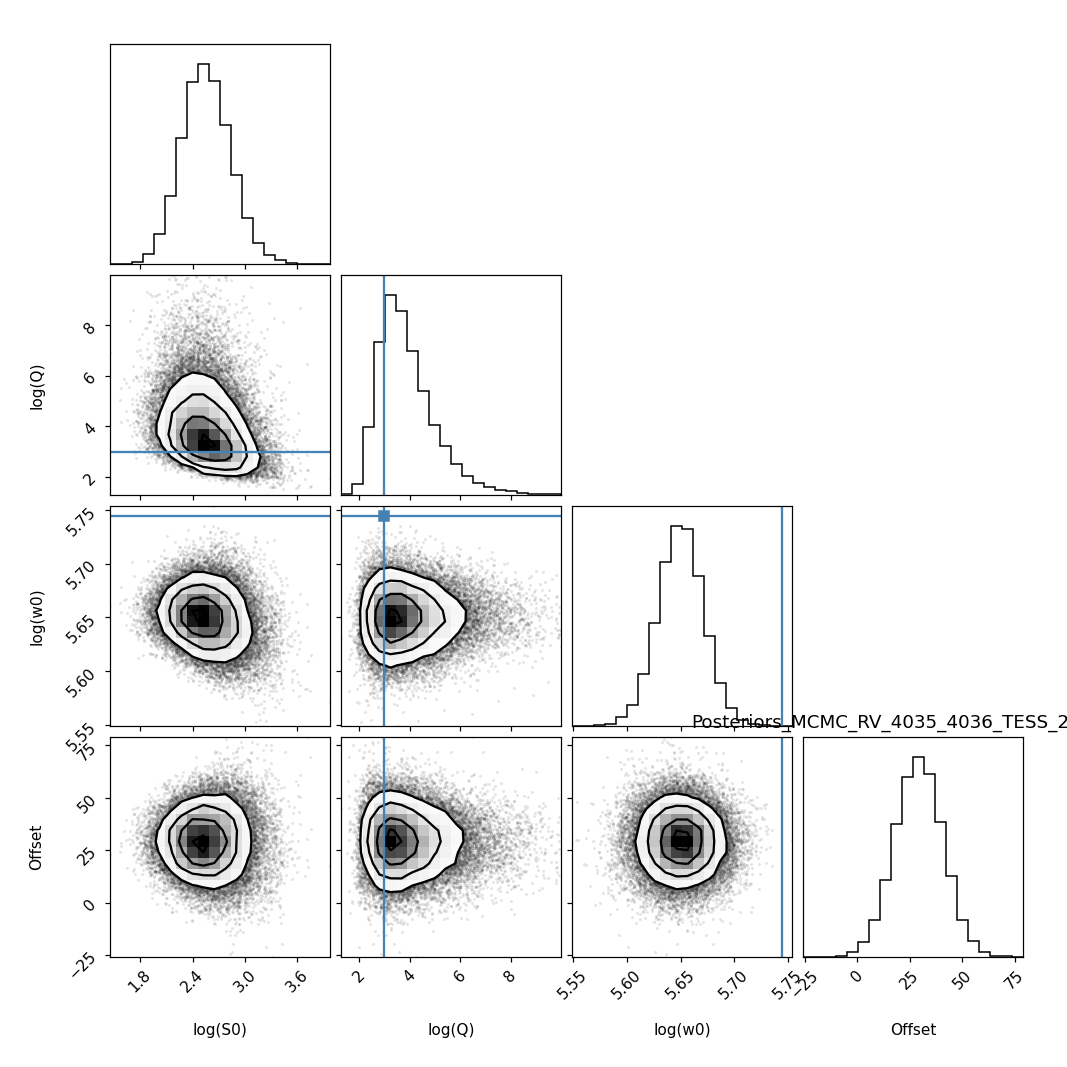

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


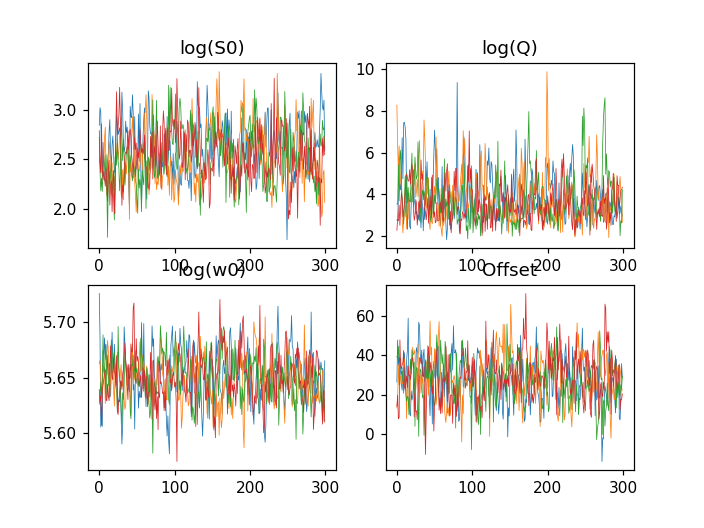

<IPython.core.display.Javascript object>


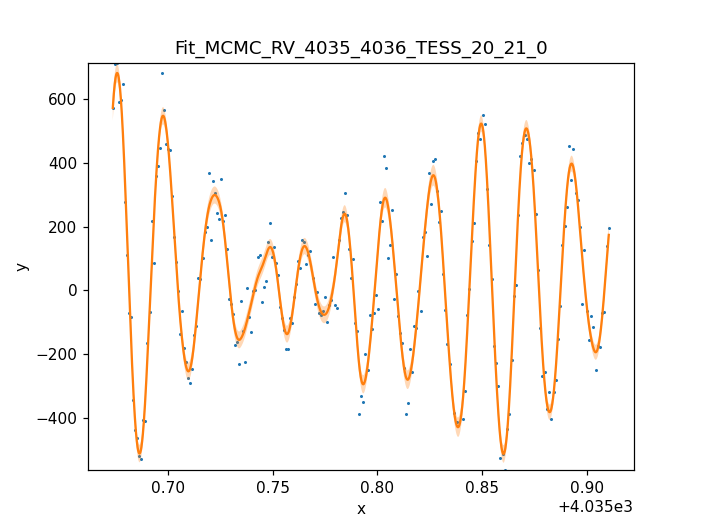

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

284.36552080496506
periode : 31.817453876710037 min


In [92]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))

bnds = np.array([3320,3340,3492,3494,3666,3668,3711,3712,3713,3768,3769,3770,3771,3772,3773,3774,3849,3905,4007,4035,4036,4038,4039,4060,4093,4094,4095,4206,4207,4208,4226,4227,4228,4229,4230,4231,4238,4239,4242,4243,4244,4525,4786,4787,4789,4827,4828,4829,4905,4906,4908,4909,4921,4922,4923,4924])
# bnds = np.array([4035,4036])
# file = open("res_TESS_20_21_0_RV_single_obs.txt",'a')
# bnds = np.array([4206,4209])
for j in range(len(bnds)-1) :
    print(j)
    rv_time = rv_data[:,0]
    rv_flux = rv_data[:,1]
    rv_error = rv_data[:,2]
    index = np.argwhere(rv_time>=3333)
    rv_flux = np.ndarray.flatten(rv_flux[index])*1000
    rv_time = np.ndarray.flatten(rv_time[index])
    rv_error = np.ndarray.flatten(rv_error[index])*1000
    
    ### Data à traiter ###
    index = np.argwhere((rv_time>bnds[j])&(rv_time<bnds[j+1]))
    rv_flux = np.ndarray.flatten(rv_flux[index])
    index = np.argwhere((rv_time>bnds[j])&(rv_time<bnds[j+1]))
    rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
    rv_error = np.ndarray.flatten(rv_error[index])

    gp = gp_building(posteriors,rv_time,rv_error)


    sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)

    ## Posteriors ###
    
    flat_samples = sampler.get_chain(discard = 500,thin=15, flat=True)
    labels = ["log(S0)","log(Q)","log(w0)","Offset"]

    rv_posteriors = np.array([])
    rv_posteriors_errors = np.array([])
    corner.corner(flat_samples, labels=labels, truths=[None,posteriors[1],posteriors[2],None])
    plt.title("Posteriors_MCMC_RV_%s_%s_TESS_20_21_0"%(bnds[j],bnds[j+1]))
#     plt.savefig(dir+"obs/Posteriors_MCMC_RV_%s_%s_TESS_20_21_0.pdf"%(bnds[j],bnds[j+1]),bbox_inches='tight')
#     plt.close()  
    plt.show()
    
    not_flat_samplers = sampler.get_chain(discard = 500, thin=15,flat=False)
    fig,ax = plt.subplots(2,2)
    for i in range(not_flat_samplers.shape[2]) :
        for cpt in range(2) :
            for cpt_1 in range(2) :
                if cpt == 0 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
                if cpt == 1 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])
                    
#     plt.savefig(dir+"obs/Samplers_MCMC_RV_%s_%s_TESS_20_21_0.pdf"%(bnds[j],bnds[j+1]),bbox_inches='tight')
#     plt.close() 
    plt.show()
    x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
    pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    plt.figure()
    plt.scatter(rv_time,rv_flux,s=1)
    plt.plot(x, pred_mean, color=color)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(np.min(rv_flux),np.max(rv_flux))
    plt.title("Fit_MCMC_RV_%s_%s_TESS_20_21_0"%(bnds[j],bnds[j+1]))
#     plt.savefig(dir+"obs/Fit_MCMC_RV_%s_%s_TESS_20_21_0.pdf"%(bnds[j],bnds[j+1]),bbox_inches='tight')
#     plt.close() 
    plt.show()

    for i in range(flat_samples.shape[1]):

        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        value = np.percentile(flat_samples[:, i], [50])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        rv_posteriors = np.append(rv_posteriors,value)
        rv_posteriors_errors = np.append(rv_posteriors_errors,q)
        
    w = np.exp(rv_posteriors[2])
    print(w)
    f = w/(2*np.pi)
    f
    P = 1/f
    
    results = np.array([])
    results = np.append(results,bnds[j])
    results = np.append(results,bnds[j+1])
    results = np.append(results,likelihood)
    results = np.append(results,rv_posteriors)
    results = np.append(results,rv_posteriors_errors)

    print("periode :",P*24*60,"min")
#     np.savetxt(file,results.reshape(1, results.shape[0]))
# file.close()

In [80]:
file = open("res_TESS_20_21_0_RV_groups_moy_single_obs.txt",'w')
file.write("Borne_inf Borne_sup Likelihood log(S0) log(Q) log(w0) Offset Errors_inf S0,Q,w0,Offset Errors_sup S0,Q,w0,Offset\n")
file.close()

In [81]:
results_data = np.loadtxt("res_TESS_20_21_0_RV_single_obs.txt",usecols=(3,4,5,6,7,8,9,10,11,12,13,14),skiprows=1)
bnds = np.array([3320,3340,3492,3494,3666,3668,3711,3712,3713,3768,3769,3770,3771,3772,3773,3774,3849,3905,4007,4035,4036,4038,4039,4060,4093,4094,4095,4206,4207,4208,4226,4227,4228,4229,4230,4231,4238,4239,4242,4243,4244,4525,4786,4787,4789,4827,4828,4829,4905,4906,4908,4909,4921,4922,4923,4924])
groups_bnds = np.array([3320,3340,3492,3666,3711,3768,3849,3905,4007,4035,4060,4093,4206,4226,4238,4525,4786,4827,4905,4921,4924])
indexes = np.array([])
file = open("res_TESS_20_21_0_RV_groups_moy_single_obs.txt",'a')
for i in range(len(groups_bnds)) :
    index = np.argwhere(groups_bnds[i] == bnds)
    indexes = np.append(indexes,index)
    
indexes = np.ndarray.flatten(np.array(indexes)).astype(int)


for i in range(len(indexes)-1) :
    moyenne = np.mean(results_data[indexes[i]:indexes[i+1],0:3],axis=0)
    moyenne_errors = np.mean(results_data[indexes[i]:indexes[i+1],3:],axis=0)
    results = np.array([])
    results = np.append(results,bnds[indexes[i]])
    results = np.append(results,bnds[indexes[i+1]])
    results = np.append(results,0)
    results = np.append(results,moyenne)
    results = np.append(results,moyenne_errors)
    np.savetxt(file,results.reshape(1, results.shape[0]))
file.close()

In [82]:
file = open("res_TESS_20_21_0_RV_groups_obs.txt",'w')
file.write("Borne_inf Borne_sup Likelihood log(S0) log(Q) log(w0) Offset Errors_inf S0,Q,w0,Offset Errors_sup S0,Q,w0,Offset\n")
file.close()

In [83]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))

groups_bnds = np.array([3320,3340,3492,3666,3711,3768,3849,3905,4007,4035,4060,4093,4206,4226,4238,4525,4786,4827,4905,4921,4924])
file = open("res_TESS_20_21_0_RV_groups_obs.txt",'a')
for j in range(len(groups_bnds)-1) :
    print(j)
    rv_time = rv_data[:,0]
    rv_flux = rv_data[:,1]
    rv_error = rv_data[:,2]
    index = np.argwhere(rv_time>=3333)
    rv_flux = np.ndarray.flatten(rv_flux[index])
    rv_time = np.ndarray.flatten(rv_time[index])
    rv_error = np.ndarray.flatten(rv_error[index])
    
    
    ### Data à traiter ###
    index = np.argwhere((rv_time>groups_bnds[j])&(rv_time<groups_bnds[j+1]))
    rv_flux = np.ndarray.flatten(rv_flux[index])
    index = np.argwhere((rv_time>groups_bnds[j])&(rv_time<groups_bnds[j+1]))
    rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
    rv_error = np.ndarray.flatten(rv_error[index])
    
    gp = gp_building(posteriors,rv_time,rv_error)


    sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)

    ## Posteriors ###
    flat_samples = sampler.get_chain(flat=True)
    labels = ["log(S0)","log(Q)","log(w0)","Offset"]

    rv_posteriors = np.array([])
    rv_posteriors_errors = np.array([])
    fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4),None])
    plt.title("Posteriors_MCMC_grp_RV_%s_%s_TESS_20_21_0"%(groups_bnds[j],groups_bnds[j+1]))
    plt.savefig(dir+"grp/Posteriors_MCMC_grp_RV_%s_%s_TESS_20_21_0.pdf"%(groups_bnds[j],groups_bnds[j+1]),bbox_inches='tight')
    plt.close()  
    
    
    not_flat_samplers = sampler.get_chain(flat=False)
    fig,ax = plt.subplots(2,2)
    for i in range(not_flat_samplers.shape[2]) :
        for cpt in range(2) :
            for cpt_1 in range(2) :
                if cpt == 0 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
                if cpt == 1 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])
                    
    plt.savefig(dir+"grp/Samplers_MCMC_grp_RV_%s_%s_TESS_20_21_0.pdf"%(groups_bnds[j],groups_bnds[j+1]),bbox_inches='tight')
    plt.close() 
    
    
    x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
    pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    plt.figure()
    plt.scatter(rv_time,rv_flux,s=1)
    plt.plot(x, pred_mean, color=color)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(np.min(rv_flux),np.max(rv_flux))
    plt.title("Fit_MCMC_grp_RV_%s_%s_TESS_20_21_0"%(groups_bnds[j],groups_bnds[j+1]))
    plt.savefig(dir+"grp/Fit_MCMC_grp_RV_%s_%s_TESS_20_21_0.pdf"%(groups_bnds[j],groups_bnds[j+1]),bbox_inches='tight')
    plt.close() 

    for i in range(flat_samples.shape[1]):

        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        value = np.percentile(flat_samples[:, i], [50])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        rv_posteriors = np.append(rv_posteriors,value)
        rv_posteriors_errors = np.append(rv_posteriors_errors,q)
        
    w = np.exp(rv_posteriors[2])
    print(w)
    f = w/(2*np.pi)
    f
    P = 1/f
    
    results = np.array([])
    results = np.append(results,groups_bnds[j])
    results = np.append(results,groups_bnds[j+1])
    results = np.append(results,likelihood)
    results = np.append(results,rv_posteriors)
    results = np.append(results,rv_posteriors_errors)

    print("periode :",P*24*60,"min")
    np.savetxt(file,results.reshape(1, results.shape[0]))
file.close()

  0%|          | 0/500 [00:00<?, ?it/s]

0
Initial log likelihood: 33.39655093041984
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<02:48, 29.70it/s]

Running production...


100%|██████████| 5000/5000 [01:39<00:00, 50.48it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -11.605081510827876), ('kernel:log_Q', 6.53866497343146), ('kernel:log_omega0', 5.603288743954332), ('mean:value', -0.15718216584095074)])

Final MCMC log likelihood: 41.0464883737797


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

246.50470917283133
periode : 36.70431641123314 min
1
Initial log likelihood: 38.78153929255398
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:42<00:00, 48.97it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -9.804188093913961), ('kernel:log_Q', 2.8620143418967197), ('kernel:log_omega0', 5.772469747944511), ('mean:value', -0.14100963321783327)])

Final MCMC log likelihood: 45.19343658084333


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

326.86291415694365
periode : 27.680677282324837 min
2
Initial log likelihood: 9.147333153112303
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/5000 [00:00<02:57, 28.17it/s]

Running production...


100%|██████████| 5000/5000 [01:29<00:00, 55.58it/s]


Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -13.592507259558829), ('kernel:log_Q', 6.551094778774894), ('kernel:log_omega0', 5.551460823737035), ('mean:value', 0.03811199843459026)])

Final MCMC log likelihood: 11.605603776082244


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

247.78744867240567
periode : 36.514306478454785 min
3
Initial log likelihood: 111.20250630885508
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:53<00:00, 43.92it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -11.151735579370731), ('kernel:log_Q', 4.100501187810735), ('kernel:log_omega0', 5.702331891516708), ('mean:value', 0.09540443557646112)])

Final MCMC log likelihood: 124.1985694460293


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

297.1059474707473
periode : 30.45306537739181 min
4
Initial log likelihood: 113.32252003337521
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/5000 [00:00<02:07, 39.21it/s]

Running production...


100%|██████████| 5000/5000 [02:01<00:00, 41.23it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -9.879559102784313), ('kernel:log_Q', 3.3561742636153227), ('kernel:log_omega0', 5.633008672727331), ('mean:value', 0.09579889141209598)])

Final MCMC log likelihood: 140.03520530484627


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

288.9838092849374
periode : 31.308974937822576 min
5
Initial log likelihood: 768.1309245794805
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:21<00:00, 23.21it/s]


Running production...


100%|██████████| 5000/5000 [03:34<00:00, 23.35it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -11.03001545922449), ('kernel:log_Q', 2.3923179013591827), ('kernel:log_omega0', 5.67697579165549), ('mean:value', 0.0712342960574928)])

Final MCMC log likelihood: 834.7421004674134


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

288.5895533175753
periode : 31.351747623317685 min
6
Initial log likelihood: 29.162839772824732
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:41<00:00, 49.25it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.248977776328825), ('kernel:log_Q', 3.15788602463251), ('kernel:log_omega0', 5.802270720462738), ('mean:value', 0.16876528266053545)])

Final MCMC log likelihood: 50.906667854188704


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

309.39001021284906
periode : 29.24395275760215 min
7
Initial log likelihood: 12.183958070619338
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:27<00:00, 57.14it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -7.51442928217539), ('kernel:log_Q', 2.4267824758498753), ('kernel:log_omega0', 5.196487203019401), ('mean:value', 0.07283632745699693)])

Final MCMC log likelihood: 5.374689587390561


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

330.92820375903307
periode : 27.340633828015434 min
8
Initial log likelihood: 58.01795571400076
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:46<00:00, 46.73it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -12.525866680310934), ('kernel:log_Q', 2.2150432874778994), ('kernel:log_omega0', 5.815807147234106), ('mean:value', -0.004999297964615533)])

Final MCMC log likelihood: 49.65999910332614


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

322.68803835218813
periode : 28.038804563507465 min
9
Initial log likelihood: 509.116713290816
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [03:02<00:00, 27.38it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -11.01453994267944), ('kernel:log_Q', 3.2769060118715725), ('kernel:log_omega0', 5.707732564116795), ('mean:value', 0.025806418489717244)])

Final MCMC log likelihood: 527.6183501568635


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

300.65585171032666
periode : 30.093499896539146 min
10
Initial log likelihood: 68.14743689531902
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/5000 [00:00<04:57, 16.81it/s]

Running production...


100%|██████████| 5000/5000 [01:48<00:00, 45.95it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.412734257244091), ('kernel:log_Q', 3.1435925873400326), ('kernel:log_omega0', 5.699579621018067), ('mean:value', -0.06594845368414108)])

Final MCMC log likelihood: 71.42617828556781


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

298.4376640497974
periode : 30.317174848376002 min
11
Initial log likelihood: 766.5222610184716
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:22<00:00, 22.23it/s]


Running production...


100%|██████████| 5000/5000 [03:45<00:00, 22.20it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.57121582851906), ('kernel:log_Q', 3.154135447886066), ('kernel:log_omega0', 5.729172148288315), ('mean:value', -0.0350095322549076)])

Final MCMC log likelihood: 795.52210531557


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

306.1948281002821
periode : 29.549117137195267 min
12
Initial log likelihood: 379.1101978371107
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:36<00:00, 32.01it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.67157020205401), ('kernel:log_Q', 1.9543694838253494), ('kernel:log_omega0', 5.726607197144976), ('mean:value', -0.045912232204217765)])

Final MCMC log likelihood: 377.3094278339453


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

304.27903459249063
periode : 29.735163497070907 min
13
Initial log likelihood: 415.88378164437927
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:54<00:00, 28.58it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.929589466088501), ('kernel:log_Q', 2.2901649955226158), ('kernel:log_omega0', 5.769066392834147), ('mean:value', -0.08720473242104745)])

Final MCMC log likelihood: 453.25313772384857


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

302.62917301390127
periode : 29.897272467922296 min
14
Initial log likelihood: 244.88723537028784
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:18<00:00, 36.03it/s]


Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.730151002185954), ('kernel:log_Q', 3.003950995605398), ('kernel:log_omega0', 5.698743064415832), ('mean:value', -0.05031988760718742)])

Final MCMC log likelihood: 253.59491653238229


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 4/500 [00:00<00:13, 35.71it/s]

306.77330980689084
periode : 29.493396436717553 min
15
Initial log likelihood: 146.89754853560356
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:02<00:00, 40.97it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.995723123772533), ('kernel:log_Q', 6.1126439695423995), ('kernel:log_omega0', 5.738488363998826), ('mean:value', -0.09140149046823991)])

Final MCMC log likelihood: 160.03030920509298


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 4/500 [00:00<00:14, 33.61it/s]

299.80424337742784
periode : 30.17898192637726 min
16
Initial log likelihood: 115.59557716807319
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:07<00:00, 39.31it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -9.558697673152006), ('kernel:log_Q', 2.1756337991748764), ('kernel:log_omega0', 5.703609579337853), ('mean:value', 0.022152179779192243)])

Final MCMC log likelihood: 126.43668314470005


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

302.5362614759891
periode : 29.906454182374716 min
17
Initial log likelihood: 766.1616111235198
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:20<00:00, 23.88it/s]


Running production...


100%|██████████| 5000/5000 [03:29<00:00, 23.86it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.740478275412434), ('kernel:log_Q', 2.275304076251125), ('kernel:log_omega0', 5.707619173229619), ('mean:value', 0.023011769229148264)])

Final MCMC log likelihood: 775.7687603771592


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

307.1788898256233
periode : 29.454455179113303 min
18
Initial log likelihood: 306.8350789791922
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/5000 [00:00<02:29, 33.33it/s]

Running production...


100%|██████████| 5000/5000 [02:21<00:00, 35.22it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -11.398949893848389), ('kernel:log_Q', 4.217547650241512), ('kernel:log_omega0', 5.77678166755008), ('mean:value', 0.08365200232550066)])

Final MCMC log likelihood: 303.728379530966


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

300.33242887382073
periode : 30.125907069928402 min
19
Initial log likelihood: 527.4992146087935
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9758710022967), ('kernel:log_Q', 3.0141845501662092), ('kernel:log_omega0', 5.7430224731143005), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:06, 26.78it/s]

Running production...


100%|██████████| 5000/5000 [03:01<00:00, 27.59it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -11.62132061840853), ('kernel:log_Q', 3.3502862496929433), ('kernel:log_omega0', 5.782903689955697), ('mean:value', 0.06122981309446798)])

Final MCMC log likelihood: 547.7185688620401


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

319.5719763327406
periode : 28.31220354853013 min


<IPython.core.display.Javascript object>


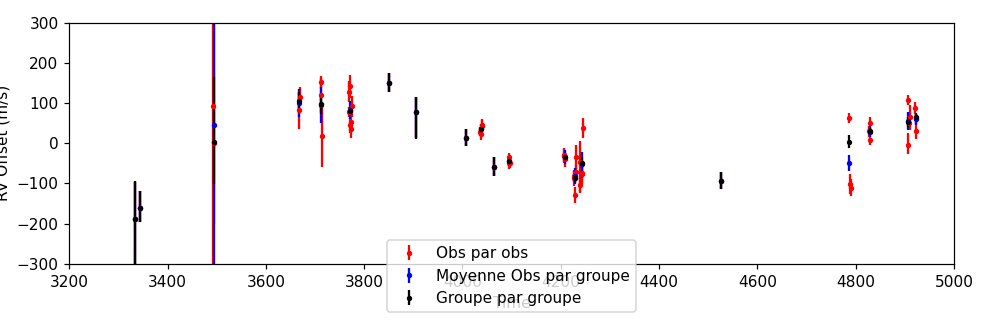

In [90]:
rv_time = rv_data[:,0]
index = np.argwhere(rv_time>=3333)
rv_time = np.ndarray.flatten(rv_time[index])
results = np.loadtxt("res_TESS_20_21_0_RV_single_obs.txt",usecols=(0,1,6,13,14),skiprows=1)
groups_moy_results = np.loadtxt("res_TESS_20_21_0_RV_groups_moy_single_obs.txt",usecols=(0,1,6,13,14),skiprows=1)
groups_results = np.loadtxt("res_TESS_20_21_0_RV_groups_obs.txt",usecols=(0,1,6,13,14),skiprows=1)
plt.figure(figsize=(9,3))
rv_time_plot_obs = np.array([])
rv_time_plot_grp = np.array([])
for i in range(len(results)) :
    mean_time_obs = np.mean(rv_time[np.argwhere((rv_time>results[i][0])&(rv_time<results[i][1]))])   
    rv_time_plot_obs = np.append(rv_time_plot_obs,mean_time_obs)
    
for j in range(len(groups_results)) :
    mean_time_grp = np.mean(rv_time[np.argwhere((rv_time>groups_results[j][0])&(rv_time<groups_results[j][1]))])
    rv_time_plot_grp = np.append(rv_time_plot_grp,mean_time_grp)
    
plt.errorbar(rv_time_plot_obs,results[:,2]*1000,yerr=[results[:,3]*1000,results[:,4]*1000],fmt='.r',markersize=5,capsize=0,label="Obs par obs")
plt.errorbar(rv_time_plot_grp,groups_moy_results[:,2]*1000,yerr=[groups_moy_results[:,3]*1000,groups_moy_results[:,4]*1000],fmt='.b',markersize=5,capsize=0,label="Moyenne Obs par groupe")
plt.errorbar(rv_time_plot_grp,groups_results[:,2]*1000,yerr=[groups_results[:,3]*1000,groups_results[:,4]*1000],fmt='.k',markersize=5,capsize=0,label="Groupe par groupe")
plt.xlim(3200,5000)
plt.ylim(-300,300)
plt.legend(bbox_to_anchor=(0.5,-0.05),loc='center')
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("RV Offset (m/s)")
plt.savefig(dir+"Offsets_20_21_0_RV.pdf",bbox_inches="tight")
plt.show()

In [102]:
file = open("res_TESS_20_21_0_RV_single_obs_test.txt",'w')
file.write("Borne_inf Borne_sup Likelihood log(S0) log(Q) log(w0) Offset Errors_inf S0,Q,w0,Offset Errors_sup S0,Q,w0,Offset\n")
file.close()

In [128]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))

# bnds = np.array([540,550,780,781,799,800,829,830,847,854,913,914,1131,1132,1170,1171,1519,1520,1565,1568,1597,1598,2569,2570,2580,2585,2685,2686,2694,2695,2706,2708,2980,2989,3344,3345,3666,3669,3711,3714,3768,3775,3849,3850,4007,4008,4035,4040,4064,4065,4093,4096,4206,4029,4226,4245,4525,4526,4786,4790,4827,4830,4905,4910,4921,4924])
bnds = np.array([4007,4008,4035,4040,4064,4065,4093,4096,4206,4209,4226,4245,4525,4526,4786,4790,4827,4830,4905,4910,4921,4924])
file = open("res_TESS_20_21_0_RV_single_obs_test.txt",'a')
# bnds = np.array([4206,4209])
for j in range(np.int(len(bnds)/2)) :
    print(j)
    rv_time = rv_data[:,0]
    rv_flux = rv_data[:,1]
    rv_error = rv_data[:,2]
    index = np.argwhere(rv_time)
    rv_flux = np.ndarray.flatten(rv_flux[index])*1000
    rv_time = np.ndarray.flatten(rv_time[index])
    rv_error = np.ndarray.flatten(rv_error[index])*1000
    
    ### Data à traiter ###
    index = np.argwhere((rv_time>bnds[j*2])&(rv_time<bnds[(j*2)+1]))
    rv_flux = np.ndarray.flatten(rv_flux[index])
    index = np.argwhere((rv_time>bnds[j*2])&(rv_time<bnds[(j*2)+1]))
    rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
    rv_error = np.ndarray.flatten(rv_error[index])

    gp = gp_building(posteriors,rv_time,rv_error)


    sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)

    ## Posteriors ###
    
    flat_samples = sampler.get_chain(discard = 500,thin=15, flat=True)
    labels = ["log(S0)","log(Q)","log(w0)","Offset"]

    rv_posteriors = np.array([])
    rv_posteriors_errors = np.array([])
    corner.corner(flat_samples, labels=labels, truths=[None,posteriors[1],posteriors[2],None])
    plt.title("Posteriors_MCMC_RV_%s_%s_TESS_20_21_0"%(bnds[j*2],bnds[(j*2)+1]))
    plt.savefig(dir+"obs/test/Posteriors_MCMC_RV_%s_%s_TESS_20_21_0.pdf"%(bnds[j*2],bnds[(j*2)+1]),bbox_inches='tight')
    plt.close()  
#     plt.show()
    
    not_flat_samplers = sampler.get_chain(discard = 500, thin=15,flat=False)
    fig,ax = plt.subplots(2,2)
    for i in range(not_flat_samplers.shape[2]) :
        for cpt in range(2) :
            for cpt_1 in range(2) :
                if cpt == 0 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
                if cpt == 1 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])
                    
    plt.savefig(dir+"obs/test/Samplers_MCMC_RV_%s_%s_TESS_20_21_0.pdf"%(bnds[j*2],bnds[(j*2)+1]),bbox_inches='tight')
    plt.close() 
#     plt.show()
    x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
    pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    plt.figure()
    plt.scatter(rv_time,rv_flux,s=1)
    plt.plot(x, pred_mean, color=color)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(np.min(rv_flux),np.max(rv_flux))
    plt.title("Fit_MCMC_RV_%s_%s_TESS_20_21_0"%(bnds[j*2],bnds[(j*2)+1]))
    plt.savefig(dir+"obs/test/Fit_MCMC_RV_%s_%s_TESS_20_21_0.pdf"%(bnds[j*2],bnds[(j*2)+1]),bbox_inches='tight')
    plt.close() 
#     plt.show()

    for i in range(flat_samples.shape[1]):

        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        value = np.percentile(flat_samples[:, i], [50])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        rv_posteriors = np.append(rv_posteriors,value)
        rv_posteriors_errors = np.append(rv_posteriors_errors,q)
        
    w = np.exp(rv_posteriors[2])
    print(w)
    f = w/(2*np.pi)
    f
    P = 1/f
    
    results = np.array([])
    results = np.append(results,bnds[j*2])
    results = np.append(results,bnds[(j*2)+1])
    results = np.append(results,likelihood)
    results = np.append(results,rv_posteriors)
    results = np.append(results,rv_posteriors_errors)

    print("periode :",P*24*60,"min")
    np.savetxt(file,results.reshape(1, results.shape[0]))
file.close()

  1%|          | 4/500 [00:00<00:13, 36.70it/s]

0
Initial log likelihood: -606.4483244811016
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:48<00:00, 46.18it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 2.4974930129727593), ('kernel:log_Q', 2.5105272473650704), ('kernel:log_omega0', 5.771840581506381), ('mean:value', 11.767294605896282)])

Final MCMC log likelihood: -535.0726545622251


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

322.51685451535775
periode : 28.0536868559462 min
1
Initial log likelihood: -3922.305255606568
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [03:04<00:00, 27.04it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 2.9399588748255576), ('kernel:log_Q', 3.084699565023361), ('kernel:log_omega0', 5.716932796748092), ('mean:value', 32.03412365645828)])

Final MCMC log likelihood: -3210.3870245926864


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

300.6640866780102
periode : 30.09267565776201 min
2
Initial log likelihood: -641.4450314929454
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:14, 25.64it/s]

Running production...


100%|██████████| 5000/5000 [01:49<00:00, 45.66it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 3.1071989480038824), ('kernel:log_Q', 2.833219507412534), ('kernel:log_omega0', 5.685976191697385), ('mean:value', -79.5576410133622)])

Final MCMC log likelihood: -570.7265159877926


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

298.41818479332795
periode : 30.319153802925 min
3
Initial log likelihood: -5659.845935586252
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:23<00:00, 21.62it/s]


Running production...


100%|██████████| 5000/5000 [03:48<00:00, 21.87it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 3.0974064584654455), ('kernel:log_Q', 2.5955407754913575), ('kernel:log_omega0', 5.739711480131428), ('mean:value', -35.68285560666378)])

Final MCMC log likelihood: -4766.998072419343


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 3/500 [00:00<00:17, 28.84it/s]

306.138014809691
periode : 29.55460088144594 min
4
Initial log likelihood: -2693.552815873629
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/5000 [00:00<05:24, 15.38it/s]

Running production...


100%|██████████| 5000/5000 [02:40<00:00, 31.13it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8378405179830595), ('kernel:log_Q', 3.061147106836766), ('kernel:log_omega0', 5.730863279684397), ('mean:value', -35.07927811364562)])

Final MCMC log likelihood: -2299.7410815903177


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

304.35998529000113
periode : 29.727254828579607 min
5
Initial log likelihood: -5439.686444060873
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:22<00:00, 22.46it/s]


Running production...


100%|██████████| 5000/5000 [03:42<00:00, 22.43it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 2.892206841708149), ('kernel:log_Q', 2.533779713455242), ('kernel:log_omega0', 5.715537574266858), ('mean:value', -59.04582872610908)])

Final MCMC log likelihood: -4652.352902843746


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 3/500 [00:00<00:22, 22.39it/s]

303.35749552191345
periode : 29.82549294446237 min
6
Initial log likelihood: -1178.9745156771837
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/5000 [00:00<05:27, 15.27it/s]

Running production...


100%|██████████| 5000/5000 [02:05<00:00, 39.98it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 3.419358706969088), ('kernel:log_Q', 2.1178878076819205), ('kernel:log_omega0', 5.693312029006932), ('mean:value', -118.00044480692735)])

Final MCMC log likelihood: -1053.4396692245136


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

299.87940144283675
periode : 30.171418239486187 min
7
Initial log likelihood: -1549.9023527710583
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:13<00:00, 37.54it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 4.079323103162037), ('kernel:log_Q', 3.4453993949711155), ('kernel:log_omega0', 5.74231971605997), ('mean:value', -37.89137758115532)])

Final MCMC log likelihood: -1309.7914670489963


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

302.45204073127115
periode : 29.91478192860854 min
8
Initial log likelihood: -4894.019897964347
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:21<00:00, 22.78it/s]


Running production...


100%|██████████| 5000/5000 [03:34<00:00, 23.29it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 3.258157899979365), ('kernel:log_Q', 2.4383840770819116), ('kernel:log_omega0', 5.735654336745612), ('mean:value', 29.397914756235387)])

Final MCMC log likelihood: -4162.9257297130725


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

307.2478396119184
periode : 29.447845276200383 min
9
Initial log likelihood: -2042.5986032471396
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:14<00:00, 34.03it/s]


Running production...


100%|██████████| 5000/5000 [02:28<00:00, 33.69it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8346277921845453), ('kernel:log_Q', 3.5830915479260437), ('kernel:log_omega0', 5.727483120305092), ('mean:value', 54.73745776505487)])

Final MCMC log likelihood: -1797.8780266153967


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  1%|          | 3/500 [00:00<00:20, 24.39it/s]

300.2300608533843
periode : 30.136178957632897 min
10
Initial log likelihood: -3583.844770071264
parameter_dict:
OrderedDict([('kernel:log_S0', 8.860417736093222), ('kernel:log_Q', 2.9855393860345183), ('kernel:log_omega0', 5.7440355257013405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/5000 [00:00<05:22, 15.50it/s]

Running production...


100%|██████████| 5000/5000 [03:02<00:00, 27.36it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', 2.6804801065604447), ('kernel:log_Q', 2.985584118498681), ('kernel:log_omega0', 5.752894430223924), ('mean:value', 64.78813267687127)])

Final MCMC log likelihood: -3128.8884806600395


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

319.6991014049847
periode : 28.300945490857526 min


<IPython.core.display.Javascript object>


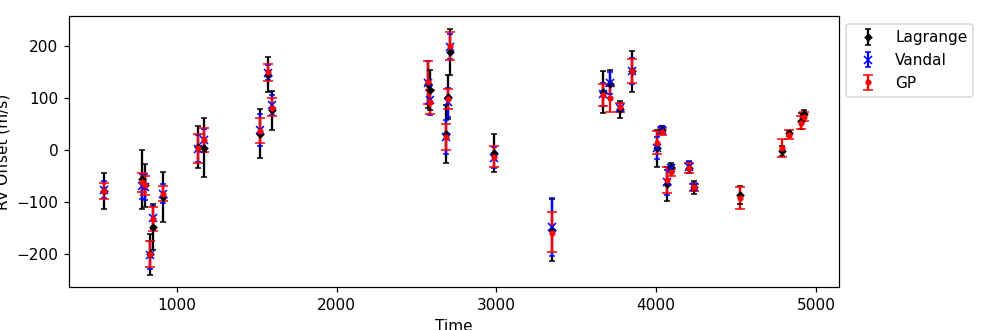

In [199]:
rv_time_plot_obs = np.array([544.4,780.71,799.71,829.66,851.32,913.54,1131.79,1170.70,1519.79,1566.70,1597.62,2569.81,2583.88,2685.70,2694.56,2707.08,2985.24,3344.74,3668.00,3712.63,3770.45,3849.51,4007.84,4037.19,4064.77,4094.64,4207.68,4233.60,4525.58,4787.42,4828.73,4907.33,4922.58])
rv_lagrange = np.array([-79,-57,-68,-201,-148,-91,6,4,31,145,76,126,115,30,102,189,-6,-154,111,127,78,151,3,38,-65,-32,-34,-72,-87,-2,32,56,69])
rv_error_lagrange = np.array([34,56,41,40,44,48,40,57,47,33,38,45,38,56,43,44,36,59,40,27,16,40,35,7,33,7,10,12,18,9,5,15,8])
rv_vandal = np.array([-76.74,-70.24,-71.54,-202.14,-130.78,-84.29,2.44,18.54,37.59,148.72,85.80,129.29,95.49,24.62,91.60,198.96,-15.44,-148.18,106.83,128.33,81.25,151.55,3.42,37.74,-62.63,-35.32,-32.82,-70.57])
rv_error_vandal = np.array([16.72,24.16,25.30,27.49,22.24,18.44,26.38,22.49,30.68,14.54,19.29,41.54,28.91,32.80,27.57,23.64,20.36,55.92,22.29,21.42,8.54,25.00,21.89,7.34,24.20,6.94,11.04,7.73])

results = np.loadtxt("res_TESS_20_21_0_RV_single_obs_test.txt",usecols=(0,1,6,13,14),skiprows=1)
    
plt.figure(figsize=(9,3))
plt.errorbar(rv_time_plot_obs[0:28],rv_lagrange[0:28],yerr=rv_error_lagrange[0:28],fmt='Dk',markersize=3,capsize=2,label="Lagrange")
plt.errorbar(rv_time_plot_obs[0:28],rv_vandal,yerr=rv_error_vandal,fmt='xb',markersize=5,capsize=2,label="Vandal")
plt.errorbar(rv_time_plot_obs[28:],rv_lagrange[28:],yerr=rv_error_lagrange[28:],fmt='Dk',markersize=3,capsize=2)
plt.errorbar(rv_time_plot_obs[0:28],results[0:28,2],yerr=[results[0:28,3],results[0:28,4]],fmt='or',markersize=3,capsize=3,label="GP")
plt.errorbar(rv_time_plot_obs[28:],results[28:,2],yerr=[results[28:,3],results[28:,4]],fmt='or',markersize=3,capsize=3)

# plt.xlim(3200,5000)
# plt.ylim(-300,300)
plt.legend(bbox_to_anchor=(1.,1.),loc='upper left')
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("RV Offset (m/s)")
plt.savefig(dir+"grp/grp_RV_Lagrange_2020/Offsets_20_21_0_RV.pdf",bbox_inches="tight")
plt.show()

In [145]:
rv_time_plot_obs[0:28]

array([ 544.4 ,  780.71,  799.71,  829.66,  851.32,  913.54, 1131.79,
       1170.7 , 1519.79, 1566.7 , 1597.62, 2569.81, 2583.88, 2685.7 ,
       2694.56, 2707.08, 2985.24, 3344.74, 3668.  , 3712.63, 3770.45,
       3849.51, 4007.84, 4037.19, 4064.77, 4094.64, 4207.68, 4233.6 ])